# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM, MultiMarginal
from mo import MultiOutputMarginal

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data

In [3]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

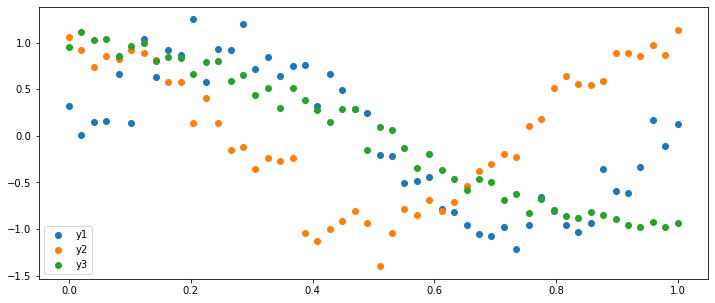

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 50)

In [8]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((50, 1), (150, 2), (150, 1))

In [9]:
n_points = 200
x_new = np.linspace(-0.5, 1.5, n_points)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [10]:
X_new.shape

(600, 2)

### ICM: one kernel

In [11]:
import aesara.tensor as at

In [12]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    
    W = np.random.rand(3,2) # (n_outputs, w_rank)
    kappa = np.random.rand(3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], input_dim=2, active_dims=[1], num_outputs=3, B=B)
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

B


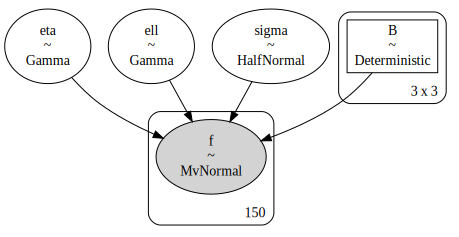

In [13]:
pm.model_to_graphviz(model)

In [14]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 18 seconds.


CPU times: user 54 s, sys: 1min 22s, total: 2min 16s
Wall time: 24.8 s


In [15]:
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

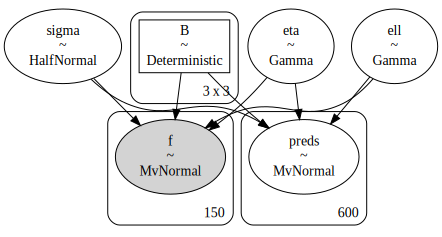

In [16]:
pm.model_to_graphviz(model)

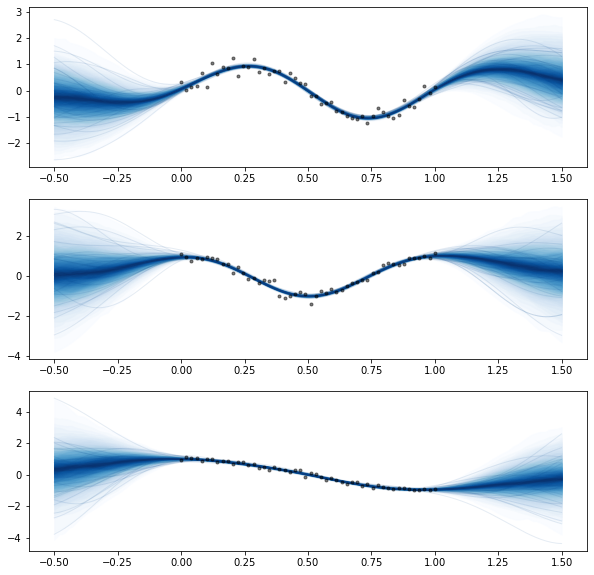

In [17]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [18]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ell,0.298,0.038,0.229,0.362,0.003,0.002,208.0,265.0,NaN
eta,1.282,0.371,0.686,1.953,0.022,0.016,264.0,270.0,NaN
sigma,0.157,0.010,0.139,0.177,0.001,0.000,319.0,241.0,NaN
"B[0, 0]",0.783,0.000,0.783,0.783,0.000,0.000,500.0,500.0,NaN
"B[0, 1]",0.503,0.000,0.503,0.503,0.000,0.000,500.0,500.0,NaN
"B[0, 2]",0.808,0.000,0.808,0.808,0.000,0.000,500.0,500.0,NaN
"B[1, 0]",0.503,0.000,0.503,0.503,0.000,0.000,500.0,500.0,NaN
"B[1, 1]",1.630,0.000,1.630,1.630,0.000,0.000,500.0,500.0,NaN
"B[1, 2]",1.065,0.000,1.065,1.065,0.000,0.000,500.0,500.0,NaN
"B[2, 0]",0.808,0.000,0.808,0.808,0.000,0.000,500.0,500.0,NaN


### LCM: two or more kernels

In [19]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Define a Multi-output GP 
    mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=3)    
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)    

None
None


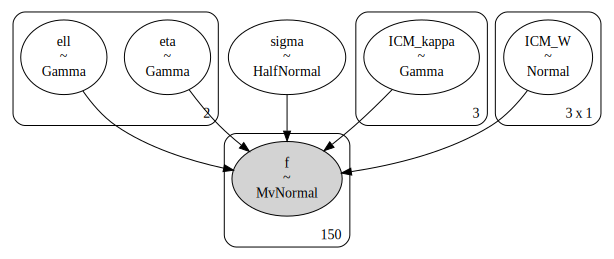

In [20]:
pm.model_to_graphviz(model)
# x1, y1
# x2, y2
# x3, y3

In [21]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 80 seconds.


CPU times: user 3min 38s, sys: 6min 49s, total: 10min 27s
Wall time: 1min 26s


In [22]:
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

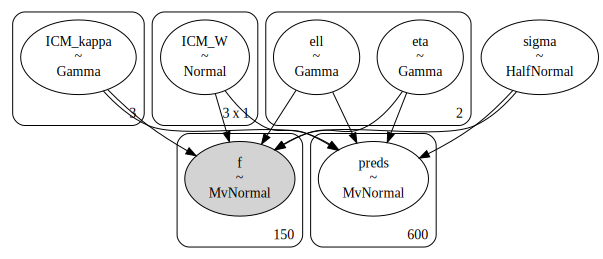

In [23]:
pm.model_to_graphviz(model)

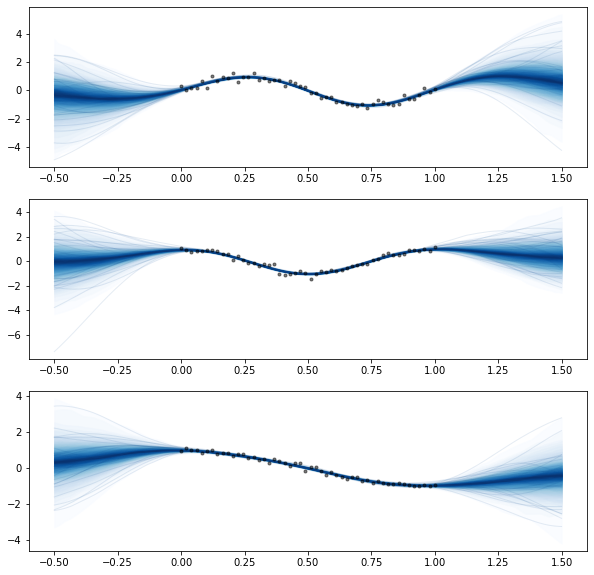

In [24]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [25]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_W[0, 0]",0.037,2.416,-4.001,4.585,0.122,0.093,403.0,436.0,NaN
"ICM_W[1, 0]",-0.013,2.546,-3.779,5.783,0.137,0.114,344.0,311.0,NaN
"ICM_W[2, 0]",-0.055,1.430,-2.756,2.630,0.077,0.069,371.0,237.0,NaN
ell[0],0.330,0.045,0.252,0.419,0.002,0.002,380.0,325.0,NaN
ell[1],4.530,2.808,0.717,9.882,0.135,0.099,353.0,331.0,NaN
eta[0],0.552,0.231,0.253,0.940,0.013,0.009,315.0,359.0,NaN
eta[1],0.496,0.441,0.006,1.223,0.020,0.015,468.0,332.0,NaN
sigma,0.156,0.010,0.136,0.174,0.000,0.000,441.0,332.0,NaN
ICM_kappa[0],5.249,2.097,1.738,8.626,0.102,0.073,395.0,315.0,NaN
ICM_kappa[1],5.213,2.155,2.004,9.487,0.084,0.059,565.0,303.0,NaN


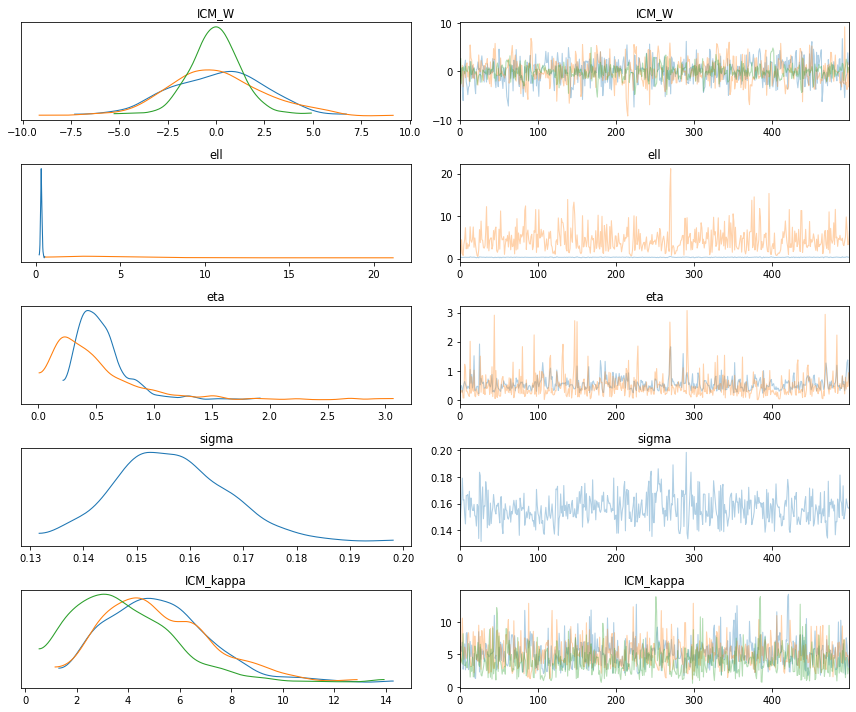

In [26]:
az.plot_trace(gp_trace);
plt.tight_layout()

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 04 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

pymc      : 4.1.5
numpy     : 1.22.4
arviz     : 0.12.1
matplotlib: 3.5.2
aesara    : 2.7.9

Watermark: 2.3.0

